# Transfer Learning
## Classifying CIFAR10 using VGG16

This handout will cover *Transfer Learning* applied to the CIFAR10 dataset. Here's the outline of we will cover:

0. Importing Data and Essential Libraries
1. Building the Classifier
2. Setting the Loss Function and Optimizer
3. Training the Model
4. Tuning the Model

## 0.Importing the Data and Essential Libraries
#### We import CIFAR10 dataset from keras and load the data.

In [ ]:
from keras.datasets import cifar10

# Fetch the data:
(X, y), (_, _) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


####  Import needed functions and libraries

In [ ]:
# Ignore the warnings - Otherwise, TensorFlow tends to innundate one with far too many warnings.
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# For matrix operations and dataframes.
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
 
# Configure some defaults.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# Useful deep learning functions.
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Powerful deep learning module.
import tensorflow as tf

# For dealing with data.
import numpy as np  

#### One hot encode the labels, and normalize the data

Just like previous exercises, we want to one hot encode our class labels. We also want to normalize our image data like we did in Assignment 3.

In [ ]:
# One-hot encode those integer values of class labels
y = to_categorical(y,10)

# Normalize all entries to the interval [0, 1]
X = X/255

In [ ]:
print("shape of X: ",X.shape)
print("shape of y: ",y.shape)

shape of X:  (50000, 32, 32, 3)
shape of y:  (50000, 10)


#### Instantiating VGG16
We create our VGG16 pretrained network, exluding the last three layers. Note that the original input to VGG16 has a shape of (224, 224, 3). But when `include_top=False` (as is the case here), we can provide our own input shape. Note that this input shape MUST EXACTLY have 3 channels and be AT LEAST 32x32. So, our CIFAR10 data barely qualifies as input to Keras' VGG16 pretrained model.

(See documentation here: https://keras.io/api/applications/vgg/#vgg16-function) 

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
# Careful about the input shape and the shape of images in your dataset
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (32, 32, 3), 
                   pooling = None)

58889256/58889256 [==============================] - 3s 0us/step


We can now investigate the architecture of the VGG16 model (excluding the original last 3 dense layer):

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### 1. Building the Classifier
Initially, we freeze the all pretrained models.

In [ ]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    layer.trainable = False

We now add the following:
* A flatten layer
* A trainable dense layer
* A softmax output layer

Note that the output layer here would have 10 neurons corresponding to the 10 classes of objects we wish to classify. For other classification tasks, make sure this is consistent with the specifics of the problem.

In [ ]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output
x = Flatten()(x)
x = Dense(units=60,activation='relu')(x)
x = Dense(units=10,activation='softmax')(x) 

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = x) 


We can also verify that the new added layers are in fact trainable while the preceeding layers from `base_model` are *freezed*. We do this by looping through the layers in the model and printing the `trainable` attribute of each layer.

In [ ]:
for i, layer in enumerate(model.layers):
  print("is layer {} trainable?".format(i+1),layer.trainable)

is layer 1 trainable? False
is layer 2 trainable? False
is layer 3 trainable? False
is layer 4 trainable? False
is layer 5 trainable? False
is layer 6 trainable? False
is layer 7 trainable? False
is layer 8 trainable? False
is layer 9 trainable? False
is layer 10 trainable? False
is layer 11 trainable? False
is layer 12 trainable? False
is layer 13 trainable? False
is layer 14 trainable? False
is layer 15 trainable? False
is layer 16 trainable? False
is layer 17 trainable? False
is layer 18 trainable? False
is layer 19 trainable? False
is layer 20 trainable? True
is layer 21 trainable? True
is layer 22 trainable? True


### 2. Setting the Loss Function and Optimizer
Here, we simply choose an appropriate loss function and optimizer and compile the model.

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# printing out a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### 3. Training the Model
#### 3.1 Preprocessing the input
For VGG16, Keras anticipates a specific format. So, we need to pre-process the input by calling `preprocess_input` method on our input.

In [ ]:
X = preprocess_input(X)

**Note**: When working with the ASL dataset, you might be using `ImageDataGenerator` class within Keras to handle your data. In that case, you'll need to pass in VGG16's `preprocess_input` function as a parameter when instantiating your `ImageDataGenerator`.

#### 3.2 Training the model
Now that the data is preprocessed, we can train the model:

In [ ]:
model_info = model.fit(X,y,batch_size=100, epochs=20, validation_split=0.2)

Epoch 1/20
400/400 [==============================] - 19s 24ms/step - loss: 2.4044 - accuracy: 0.1621 - val_loss: 2.2118 - val_accuracy: 0.1748
Epoch 2/20
400/400 [==============================] - 9s 23ms/step - loss: 2.1293 - accuracy: 0.2137 - val_loss: 2.0823 - val_accuracy: 0.2429
Epoch 3/20
400/400 [==============================] - 10s 24ms/step - loss: 2.0732 - accuracy: 0.2370 - val_loss: 2.0449 - val_accuracy: 0.2531
Epoch 4/20
400/400 [==============================] - 8s 21ms/step - loss: 2.0332 - accuracy: 0.2527 - val_loss: 2.0161 - val_accuracy: 0.2564
Epoch 5/20
400/400 [==============================] - 9s 23ms/step - loss: 2.0058 - accuracy: 0.2656 - val_loss: 1.9701 - val_accuracy: 0.2915
Epoch 6/20
400/400 [==============================] - 8s 21ms/step - loss: 1.9861 - accuracy: 0.2718 - val_loss: 1.9672 - val_accuracy: 0.2738
Epoch 7/20
400/400 [==============================] - 9s 24ms/step - loss: 1.9650 - accuracy: 0.2795 - val_loss: 1.9799 - val_accuracy: 0.27

#### 3.3 Plotting the training curve

After training, we can plot the training and validation accuracy and loss.

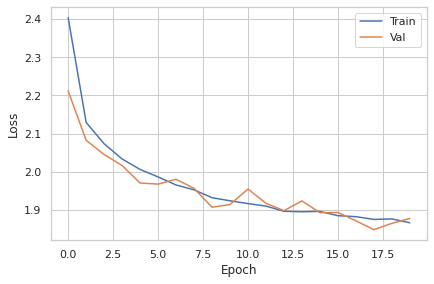

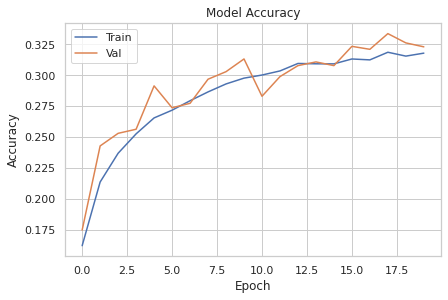

In [ ]:
def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(hist):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# Plot your losses and accuracies
plot_losses(model_info)
plot_accuracies(model_info)

### 4. Tuning the Model

#### 4.1 Adding extra layers and dropout

We can add more layers and include dropout to mitigate potential overfitting.

Using the `base_model` that we created initially, we add two new dense layers with diminishing dropout rates (0.75 and 0.25, respectively) followed by a final softmax output layer. We will then inspect the model summary one more time.


In [ ]:
# adding dense layers with dropout

x = base_model.output
x = Flatten()(x)
x = Dense(units=200,activation='relu')(x)
x = Dropout(rate=0.75)(x)
x = Dense(units=50, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output = Dense(units=10,activation='softmax')(x) 

# creating the new model
new_model = Model(inputs = base_model.input, outputs = output) 
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

#### 4.2 Compiling and training the new model
One the new model is assembled, we can compile and train it. Note that the data is already preprocessed for VGG16 in the previous part.

In [ ]:
# compiling the new model

opt = Adam()

new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# training the model
new_model_info = new_model.fit(X,y,batch_size=100, epochs=20, validation_split=0.2)

Epoch 1/20
400/400 [==============================] - 11s 25ms/step - loss: 2.8745 - accuracy: 0.1063 - val_loss: 2.2977 - val_accuracy: 0.1202
Epoch 2/20
400/400 [==============================] - 10s 24ms/step - loss: 2.2895 - accuracy: 0.1169 - val_loss: 2.2792 - val_accuracy: 0.1568
Epoch 3/20
400/400 [==============================] - 10s 24ms/step - loss: 2.2793 - accuracy: 0.1277 - val_loss: 2.2773 - val_accuracy: 0.1477
Epoch 4/20
400/400 [==============================] - 10s 24ms/step - loss: 2.2767 - accuracy: 0.1262 - val_loss: 2.2637 - val_accuracy: 0.1585
Epoch 5/20
400/400 [==============================] - 9s 21ms/step - loss: 2.2732 - accuracy: 0.1283 - val_loss: 2.2657 - val_accuracy: 0.1527
Epoch 6/20
400/400 [==============================] - 9s 22ms/step - loss: 2.2718 - accuracy: 0.1301 - val_loss: 2.2605 - val_accuracy: 0.1539
Epoch 7/20
400/400 [==============================] - 9s 22ms/step - loss: 2.2685 - accuracy: 0.1313 - val_loss: 2.2592 - val_accuracy: 0.

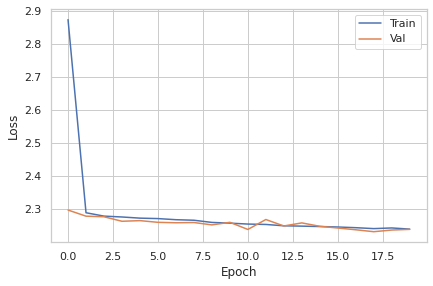

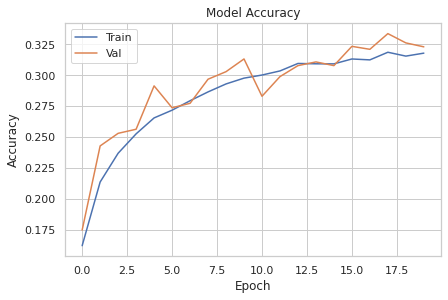

In [ ]:
# plotting accuracies and loss
plot_losses(new_model_info)
plot_accuracies(new_model_info)

We can iterate on this to improve the performance of the model by trying out different hyperparameter values.